# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [1]:
! pip install Pillow

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [3]:
! git clone https://github.com/vcasadei/MNIST.git

Cloning into 'MNIST'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10 (from 1)
Receiving objects: 100% (10/10), 11.01 MiB | 12.46 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
!ls MNIST

processed  raw


In [6]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt', weights_only=True)

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [7]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

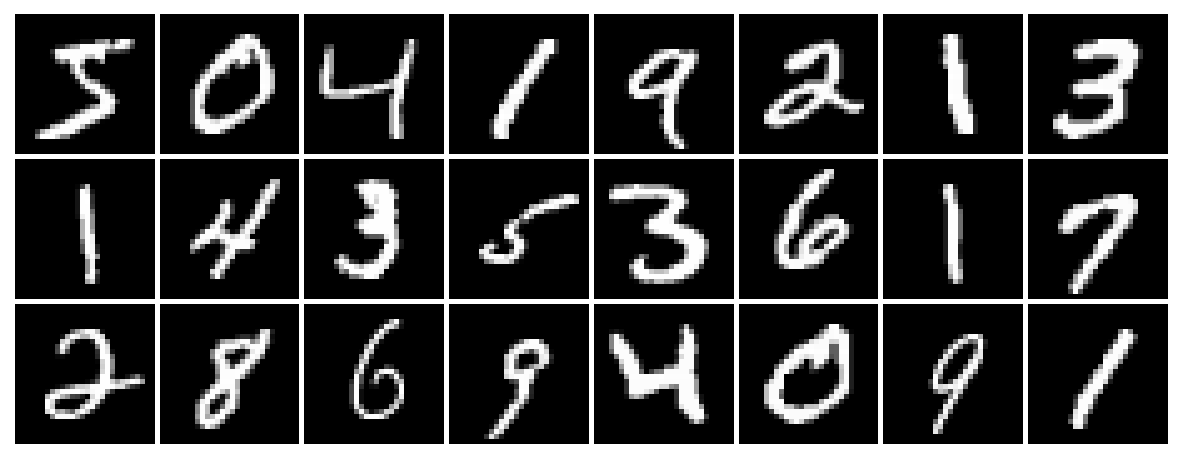

In [8]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


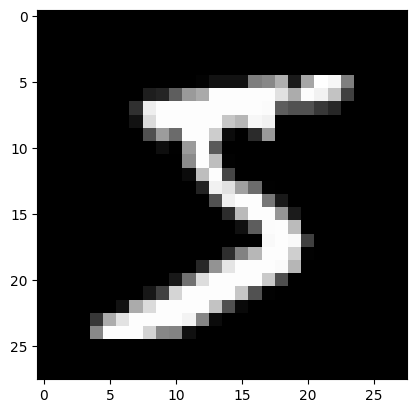

In [9]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [10]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [11]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.2113, -0.0134,  0.0457,  0.1777, -0.0752,  0.0261,  0.4572,  0.0456,
          0.1497,  0.2491],
        [ 0.3711,  0.3396,  0.1517,  0.0641, -0.2023,  0.3482,  0.2406, -0.2307,
          0.4063,  0.1638],
        [ 0.1625,  0.2142, -0.1219,  0.1284, -0.0581,  0.2300, -0.0683, -0.0753,
         -0.0850,  0.0026],
        [ 0.2060, -0.0458,  0.1595, -0.1593,  0.1623, -0.0907,  0.1578, -0.0572,
          0.0905,  0.2240],
        [-0.0572,  0.1757, -0.1829, -0.0193,  0.0974,  0.3445, -0.0905, -0.0278,
         -0.3464,  0.0899]], grad_fn=<AddmmBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [12]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [13]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-d2e3lgvc
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-d2e3lgvc
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4972 sha256=ac34c7694e8e8eb0629a30365a3ee3f3df5e93e35248aacef08362b73517950e
  Stored in directory: /tmp/pip-ephem-wheel-cache-r62vg2oq/wheels/44/5a/39/48c1209682afcfc7ad8ae7b3cf7aa0ff08a72e3ac4e5931f1d
Successfully built torchviz


In [14]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3181, grad_fn=<NllLossBackward0>)

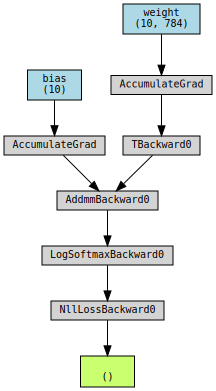

In [15]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [16]:
import numpy
losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [17]:
print('Final loss:', loss.item())

Final loss: 0.2661883533000946


### Visualizando gráfico de perda durante o treinamento

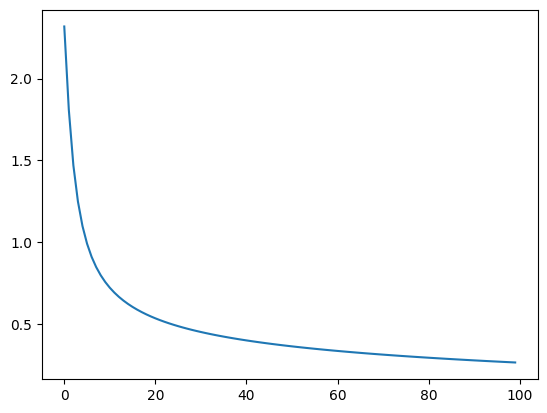

In [18]:
plt.plot(losses)

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [19]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean()
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [20]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,2,2,1,0
2,0,1,91,1,0,1,0,1,2,1
3,0,0,0,88,0,3,0,0,0,0
4,0,0,1,0,102,1,1,2,0,3
5,0,2,0,1,0,81,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,111,0,3
8,0,2,2,0,0,2,0,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


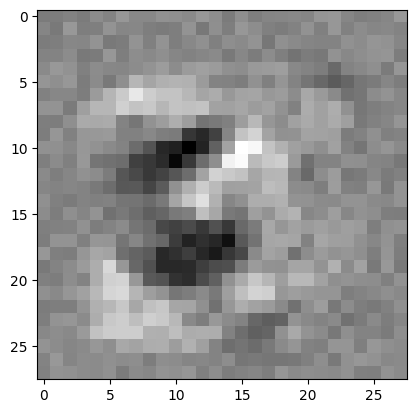

In [21]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

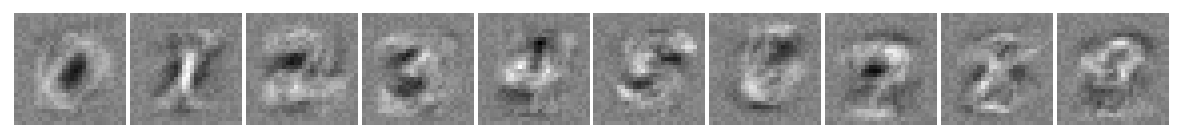

In [22]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

In [23]:
#1
model_1 = torch.nn.Linear(28*28, 10)
epochs = 100
learningRate = 0.5

criterion_1 = torch.nn.CrossEntropyLoss()
optimizer_1 = torch.optim.SGD(model.parameters(), lr=learningRate)

losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model_1(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion_1(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer_1.zero_grad()
    loss.backward()
    optimizer_1.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(f'Época {i} - Perda: {loss} Acurácia: {accuracy}')

Época 0 - Perda: 2.318251609802246 Acurácia: 0.077
Época 1 - Perda: 2.318251609802246 Acurácia: 0.077
Época 2 - Perda: 2.318251609802246 Acurácia: 0.077
Época 3 - Perda: 2.318251609802246 Acurácia: 0.077
Época 4 - Perda: 2.318251609802246 Acurácia: 0.077
Época 5 - Perda: 2.318251609802246 Acurácia: 0.077
Época 6 - Perda: 2.318251609802246 Acurácia: 0.077
Época 7 - Perda: 2.318251609802246 Acurácia: 0.077
Época 8 - Perda: 2.318251609802246 Acurácia: 0.077
Época 9 - Perda: 2.318251609802246 Acurácia: 0.077
Época 10 - Perda: 2.318251609802246 Acurácia: 0.077
Época 11 - Perda: 2.318251609802246 Acurácia: 0.077
Época 12 - Perda: 2.318251609802246 Acurácia: 0.077
Época 13 - Perda: 2.318251609802246 Acurácia: 0.077
Época 14 - Perda: 2.318251609802246 Acurácia: 0.077
Época 15 - Perda: 2.318251609802246 Acurácia: 0.077
Época 16 - Perda: 2.318251609802246 Acurácia: 0.077
Época 17 - Perda: 2.318251609802246 Acurácia: 0.077
Época 18 - Perda: 2.318251609802246 Acurácia: 0.077
Época 19 - Perda: 2.31

weights: torch.Size([10, 784])
bias:    torch.Size([10])


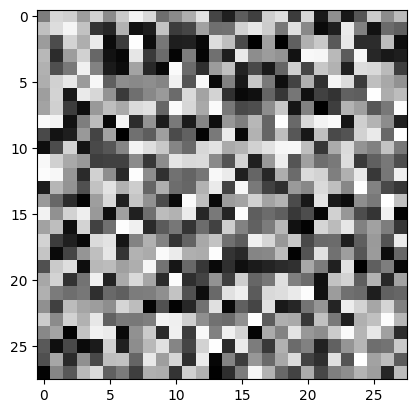

weights: torch.Size([10, 784])
bias:    torch.Size([10])


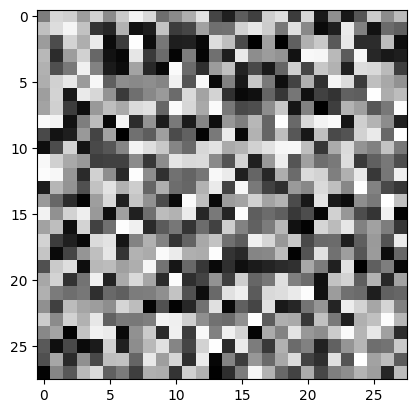

weights: torch.Size([10, 784])
bias:    torch.Size([10])


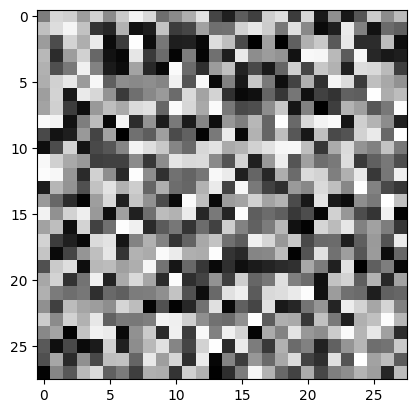

weights: torch.Size([10, 784])
bias:    torch.Size([10])


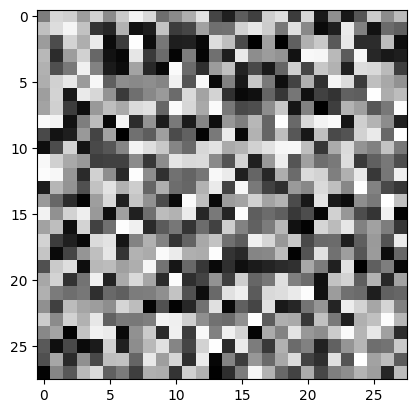

weights: torch.Size([10, 784])
bias:    torch.Size([10])


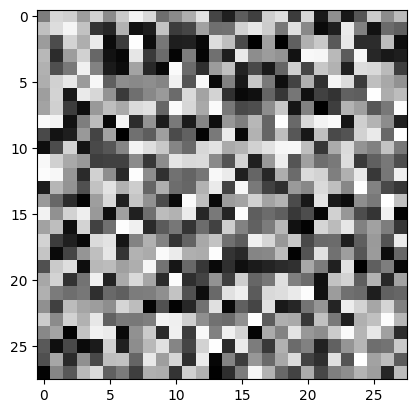

weights: torch.Size([10, 784])
bias:    torch.Size([10])


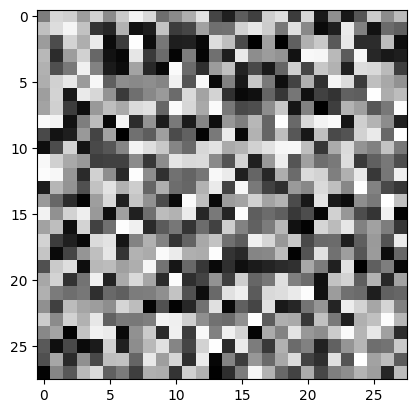

weights: torch.Size([10, 784])
bias:    torch.Size([10])


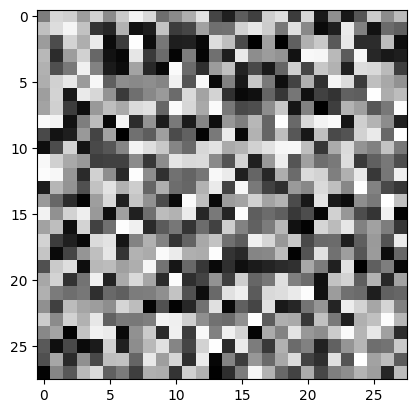

weights: torch.Size([10, 784])
bias:    torch.Size([10])


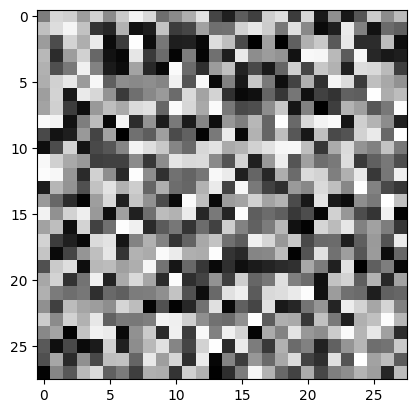

weights: torch.Size([10, 784])
bias:    torch.Size([10])


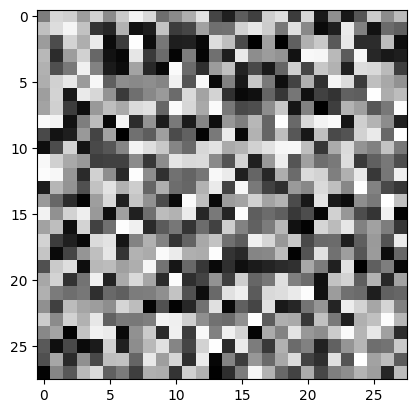

weights: torch.Size([10, 784])
bias:    torch.Size([10])


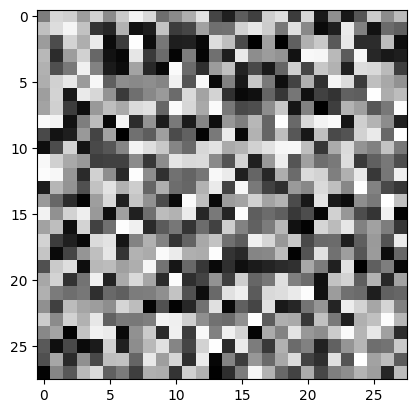

weights: torch.Size([10, 784])
bias:    torch.Size([10])


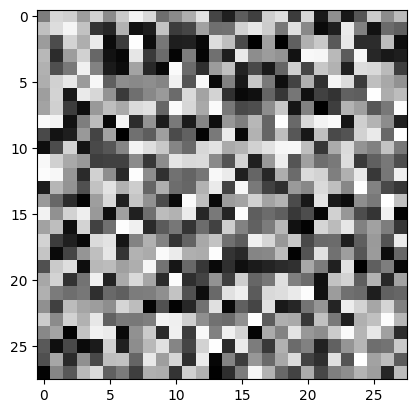

weights: torch.Size([10, 784])
bias:    torch.Size([10])


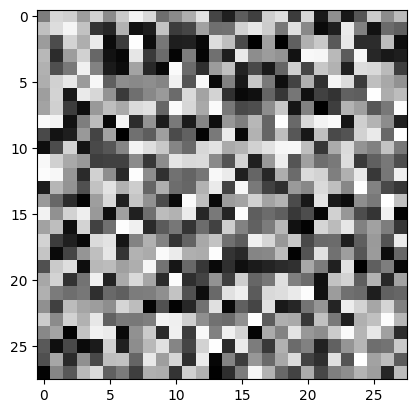

weights: torch.Size([10, 784])
bias:    torch.Size([10])


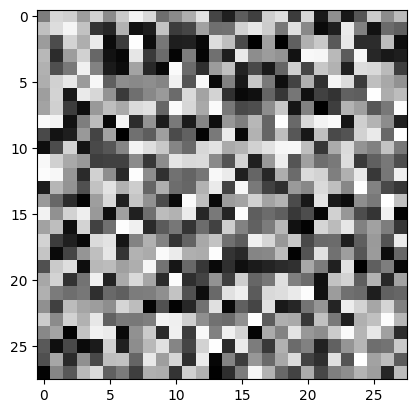

weights: torch.Size([10, 784])
bias:    torch.Size([10])


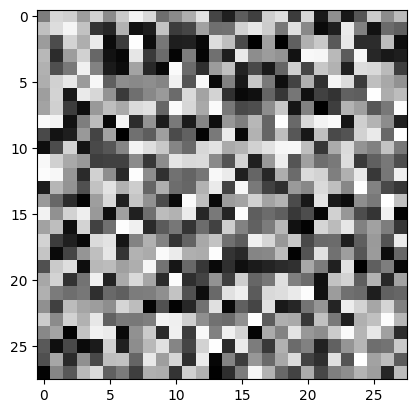

weights: torch.Size([10, 784])
bias:    torch.Size([10])


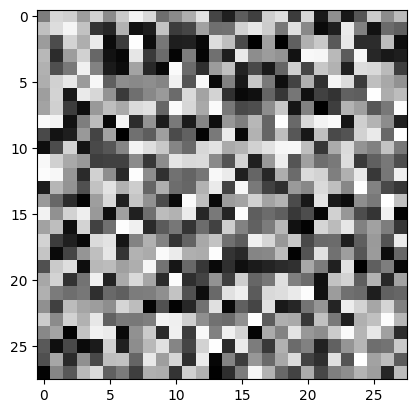

weights: torch.Size([10, 784])
bias:    torch.Size([10])


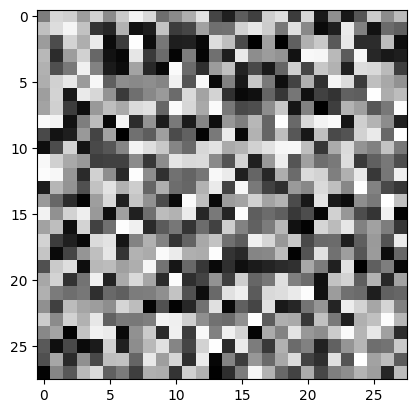

weights: torch.Size([10, 784])
bias:    torch.Size([10])


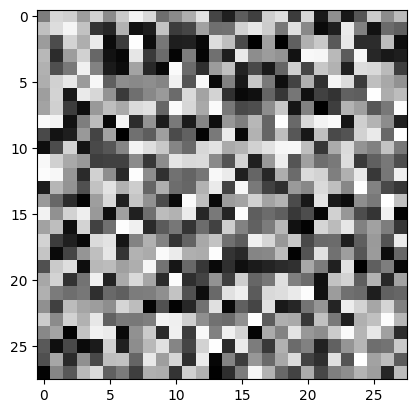

weights: torch.Size([10, 784])
bias:    torch.Size([10])


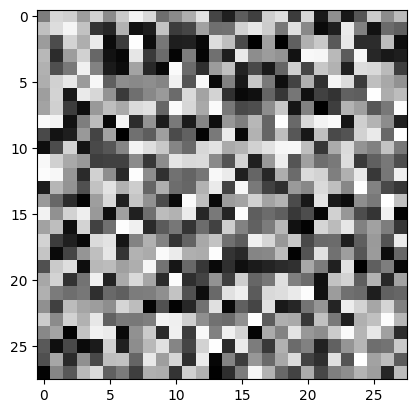

weights: torch.Size([10, 784])
bias:    torch.Size([10])


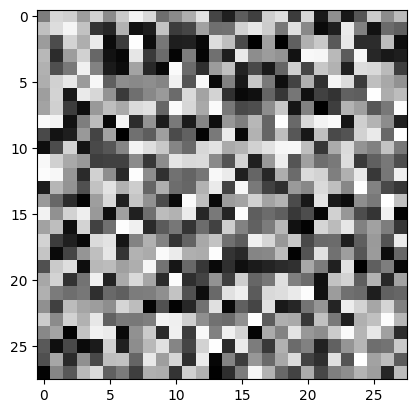

weights: torch.Size([10, 784])
bias:    torch.Size([10])


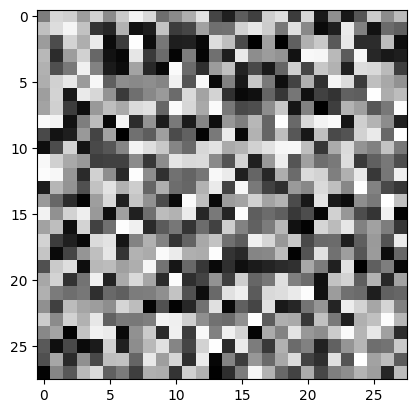

weights: torch.Size([10, 784])
bias:    torch.Size([10])


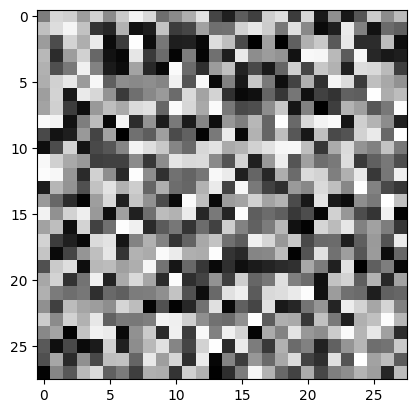

weights: torch.Size([10, 784])
bias:    torch.Size([10])


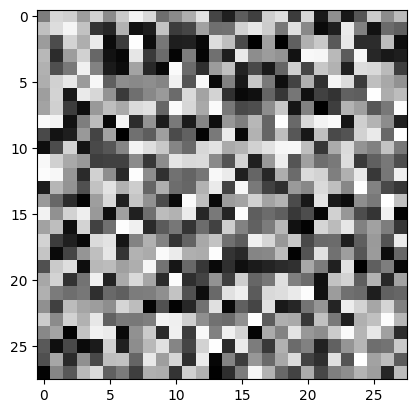

weights: torch.Size([10, 784])
bias:    torch.Size([10])


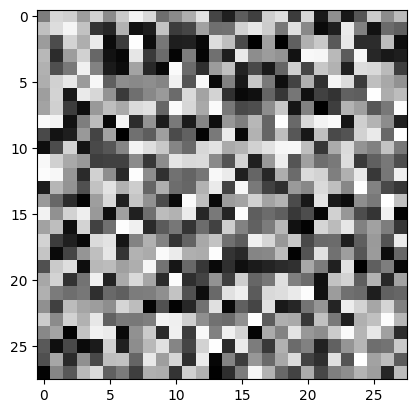

weights: torch.Size([10, 784])
bias:    torch.Size([10])


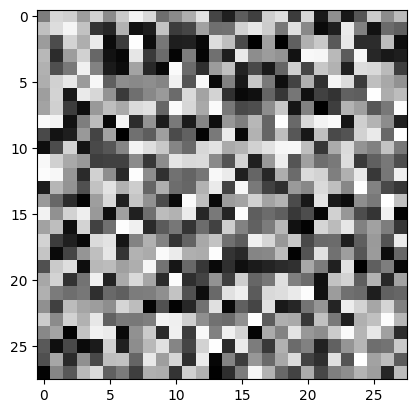

weights: torch.Size([10, 784])
bias:    torch.Size([10])


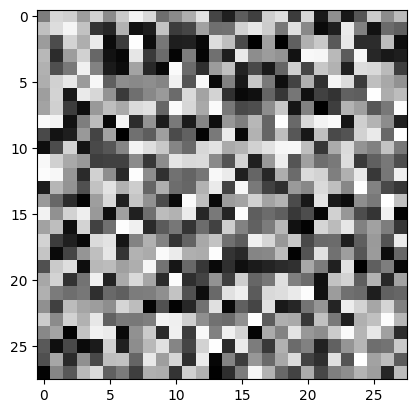

weights: torch.Size([10, 784])
bias:    torch.Size([10])


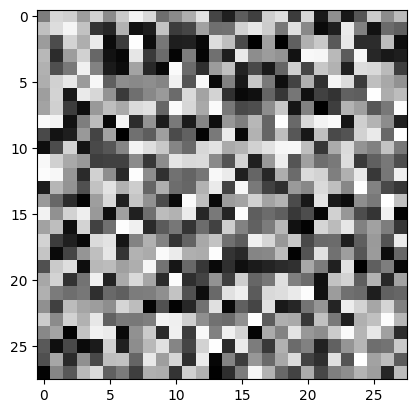

weights: torch.Size([10, 784])
bias:    torch.Size([10])


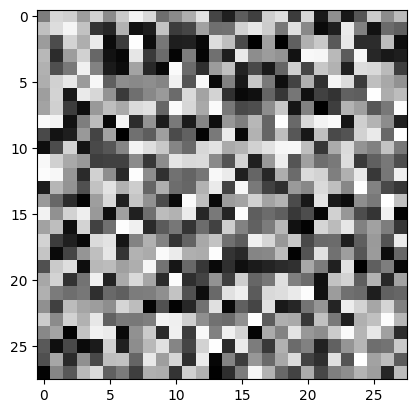

weights: torch.Size([10, 784])
bias:    torch.Size([10])


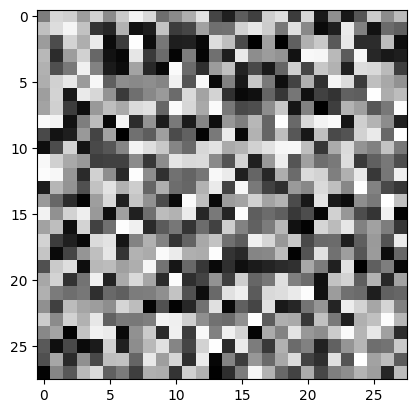

weights: torch.Size([10, 784])
bias:    torch.Size([10])


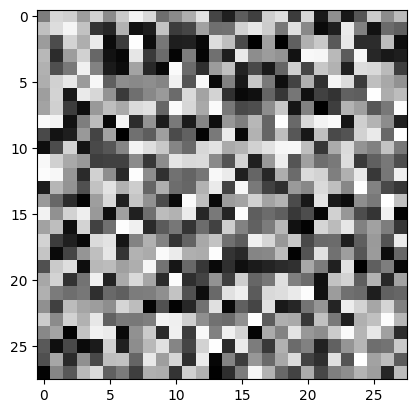

weights: torch.Size([10, 784])
bias:    torch.Size([10])


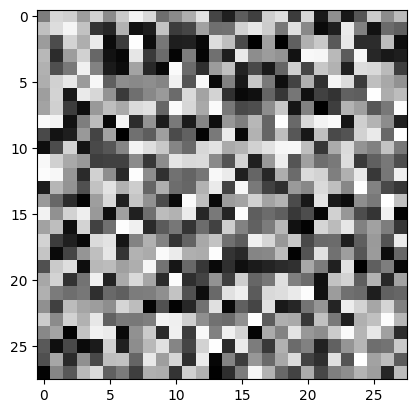

weights: torch.Size([10, 784])
bias:    torch.Size([10])


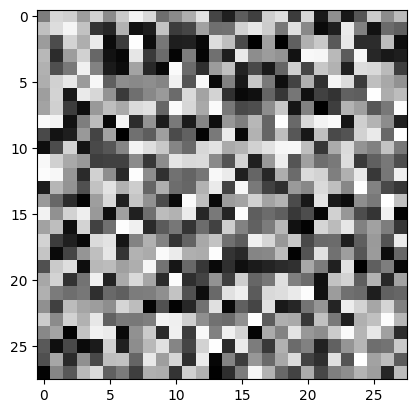

weights: torch.Size([10, 784])
bias:    torch.Size([10])


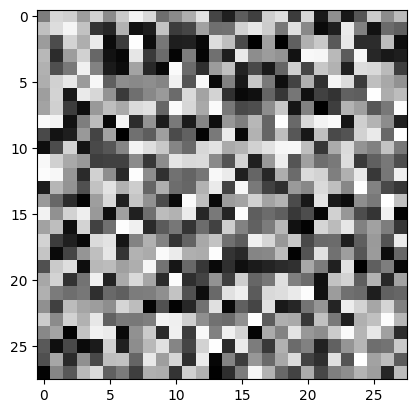

weights: torch.Size([10, 784])
bias:    torch.Size([10])


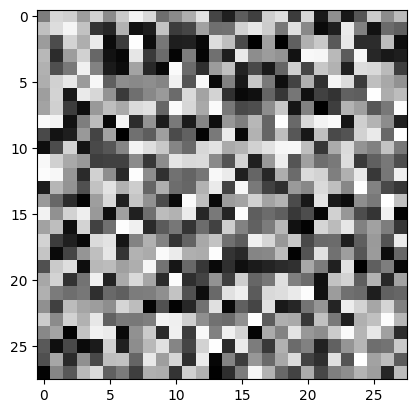

weights: torch.Size([10, 784])
bias:    torch.Size([10])


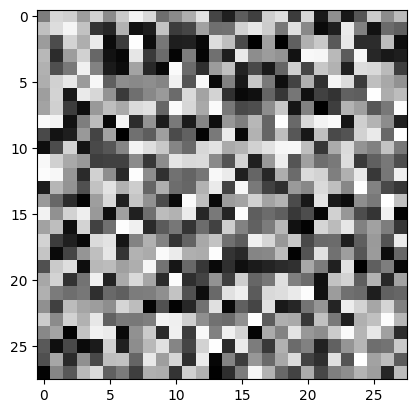

weights: torch.Size([10, 784])
bias:    torch.Size([10])


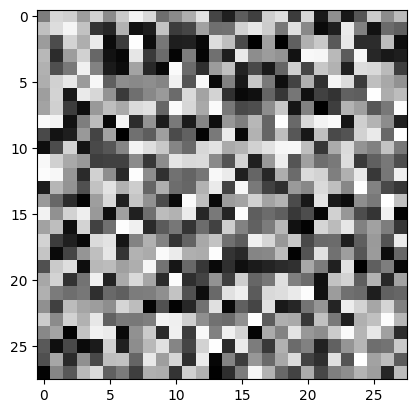

weights: torch.Size([10, 784])
bias:    torch.Size([10])


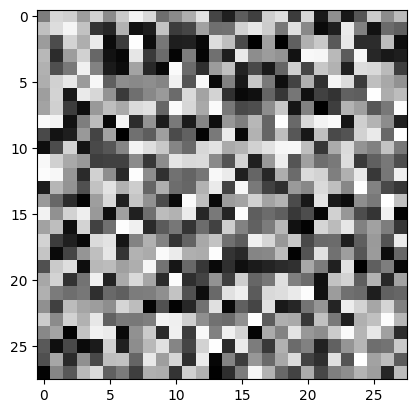

weights: torch.Size([10, 784])
bias:    torch.Size([10])


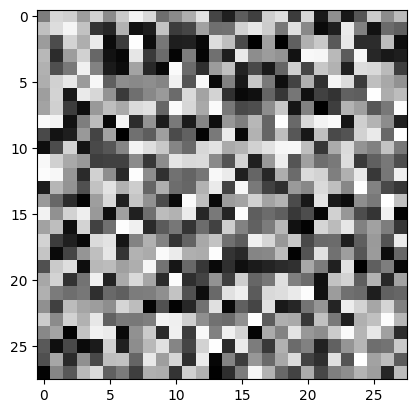

weights: torch.Size([10, 784])
bias:    torch.Size([10])


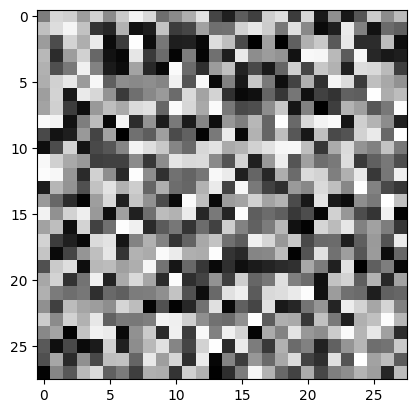

weights: torch.Size([10, 784])
bias:    torch.Size([10])


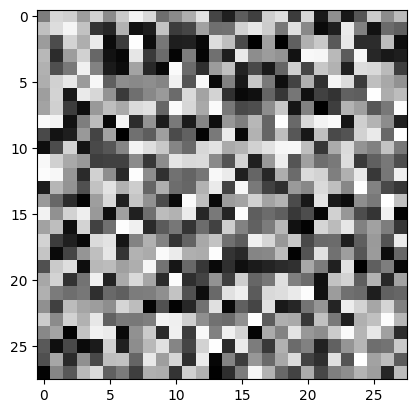

weights: torch.Size([10, 784])
bias:    torch.Size([10])


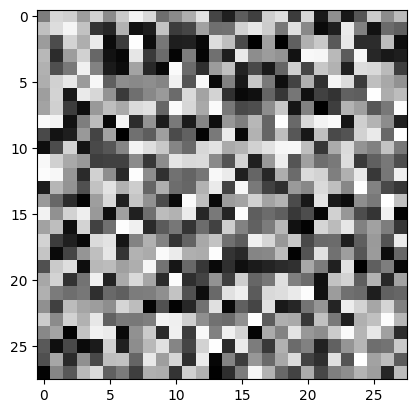

weights: torch.Size([10, 784])
bias:    torch.Size([10])


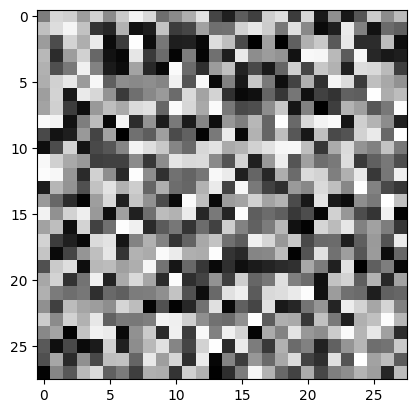

weights: torch.Size([10, 784])
bias:    torch.Size([10])


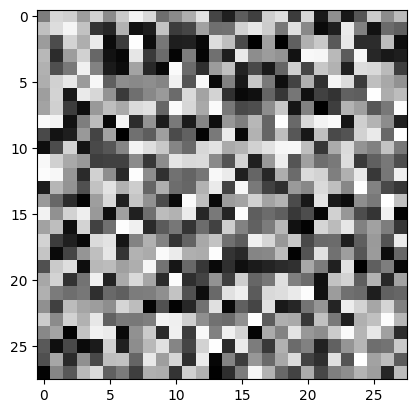

weights: torch.Size([10, 784])
bias:    torch.Size([10])


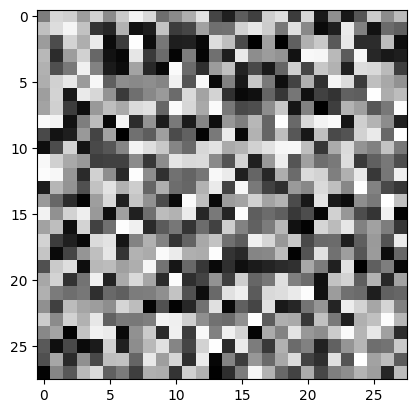

weights: torch.Size([10, 784])
bias:    torch.Size([10])


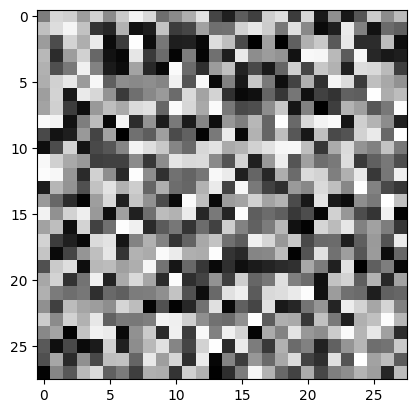

weights: torch.Size([10, 784])
bias:    torch.Size([10])


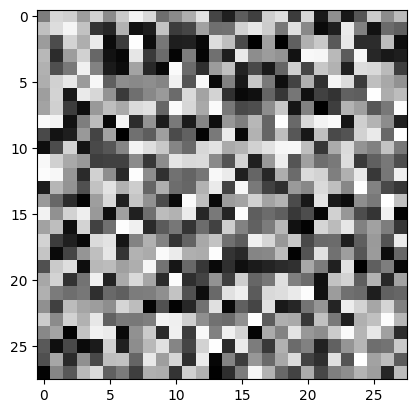

weights: torch.Size([10, 784])
bias:    torch.Size([10])


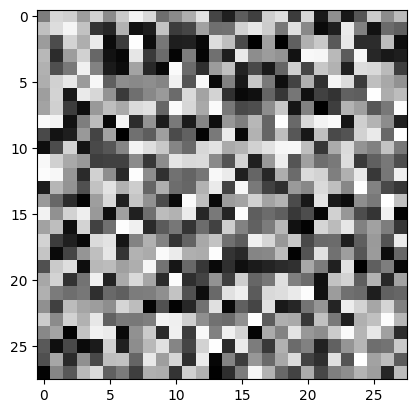

weights: torch.Size([10, 784])
bias:    torch.Size([10])


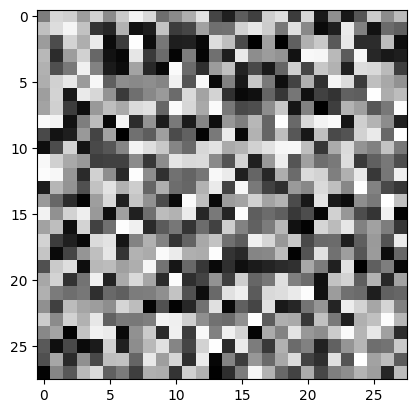

weights: torch.Size([10, 784])
bias:    torch.Size([10])


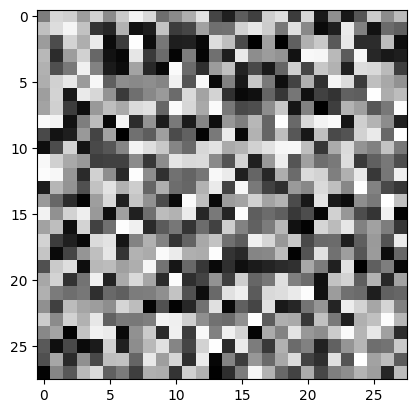

weights: torch.Size([10, 784])
bias:    torch.Size([10])


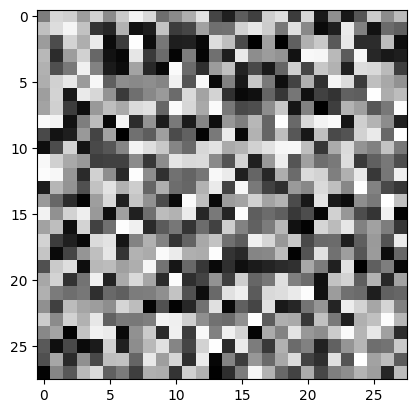

weights: torch.Size([10, 784])
bias:    torch.Size([10])


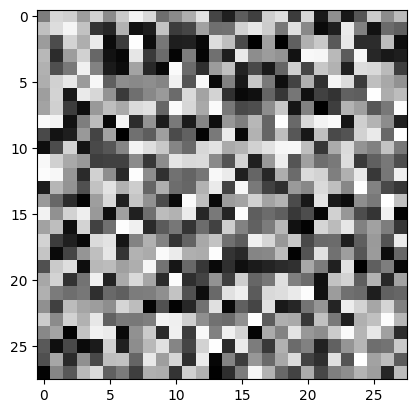

weights: torch.Size([10, 784])
bias:    torch.Size([10])


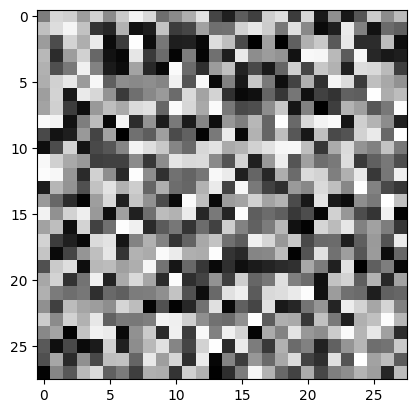

weights: torch.Size([10, 784])
bias:    torch.Size([10])


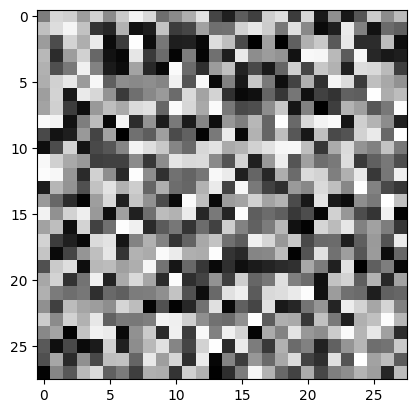

weights: torch.Size([10, 784])
bias:    torch.Size([10])


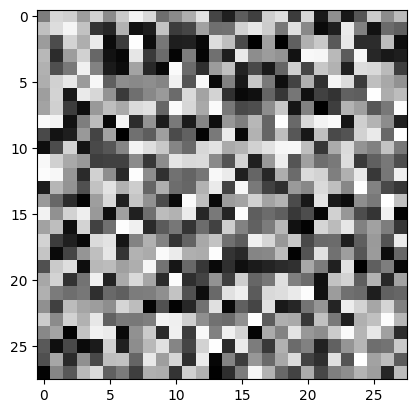

weights: torch.Size([10, 784])
bias:    torch.Size([10])


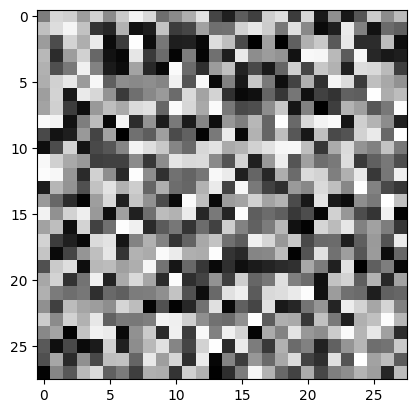

weights: torch.Size([10, 784])
bias:    torch.Size([10])


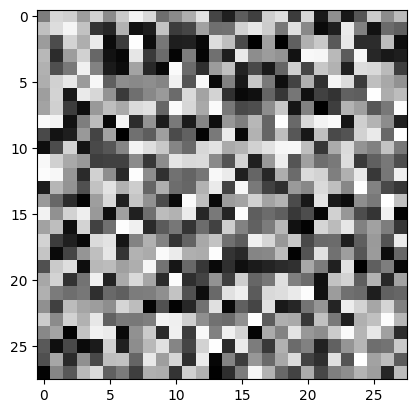

weights: torch.Size([10, 784])
bias:    torch.Size([10])


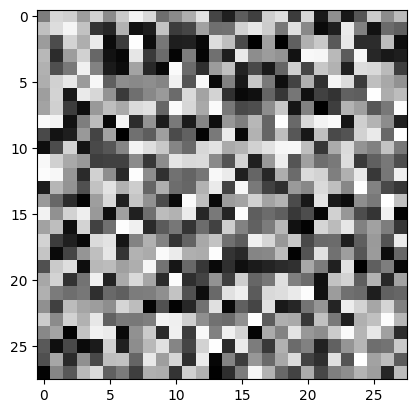

weights: torch.Size([10, 784])
bias:    torch.Size([10])


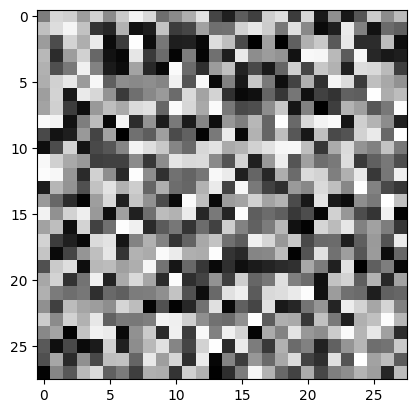

weights: torch.Size([10, 784])
bias:    torch.Size([10])


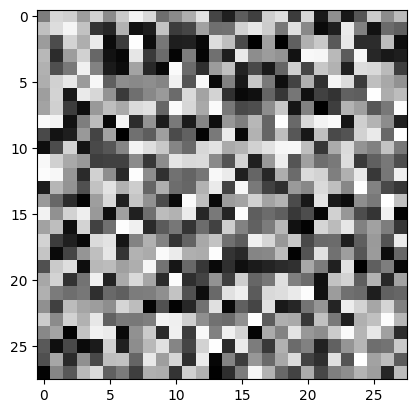

weights: torch.Size([10, 784])
bias:    torch.Size([10])


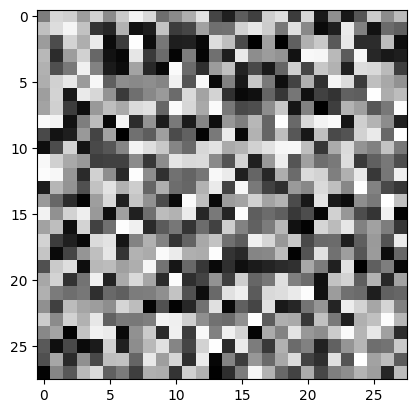

weights: torch.Size([10, 784])
bias:    torch.Size([10])


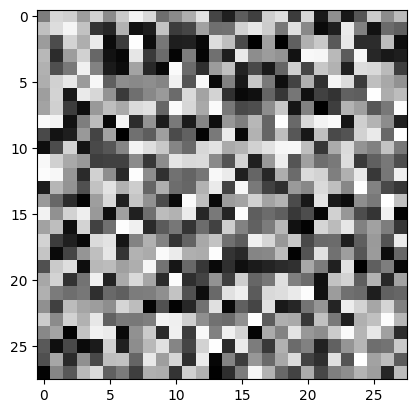

weights: torch.Size([10, 784])
bias:    torch.Size([10])


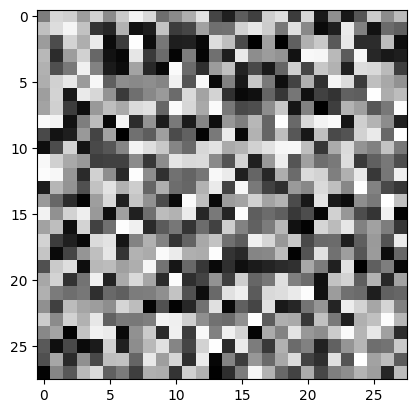

weights: torch.Size([10, 784])
bias:    torch.Size([10])


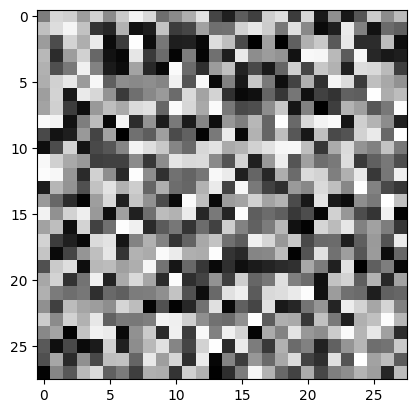

weights: torch.Size([10, 784])
bias:    torch.Size([10])


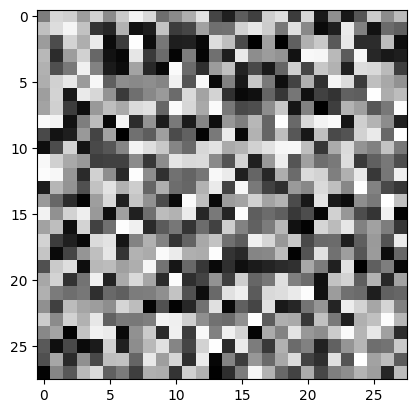

weights: torch.Size([10, 784])
bias:    torch.Size([10])


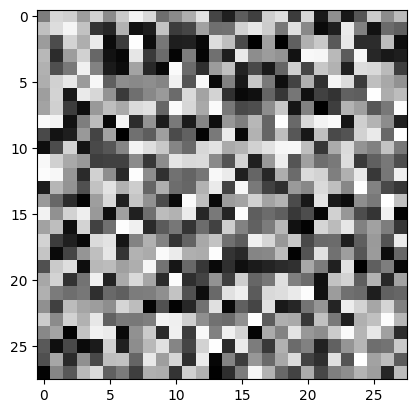

weights: torch.Size([10, 784])
bias:    torch.Size([10])


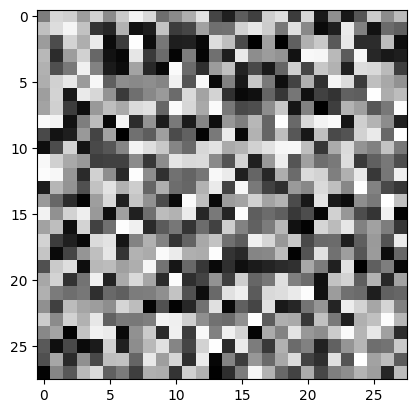

weights: torch.Size([10, 784])
bias:    torch.Size([10])


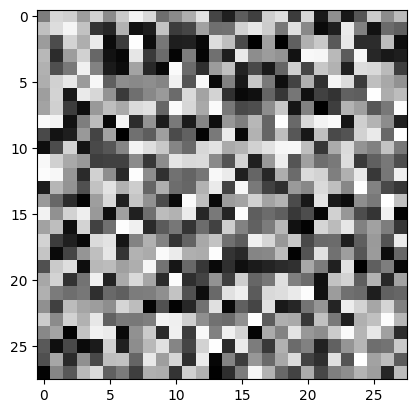

weights: torch.Size([10, 784])
bias:    torch.Size([10])


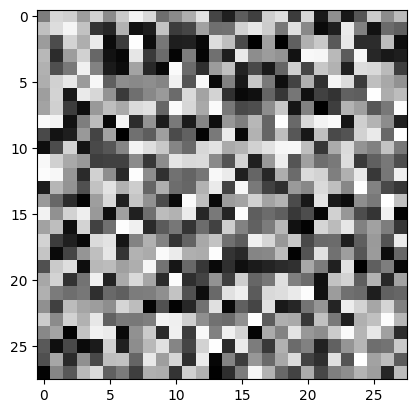

weights: torch.Size([10, 784])
bias:    torch.Size([10])


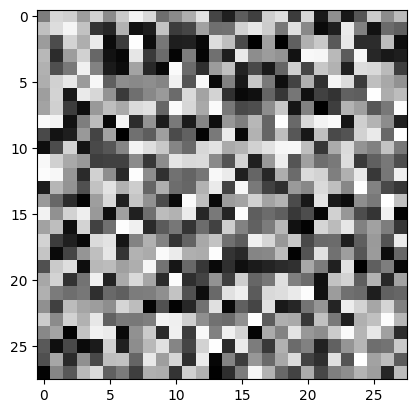

weights: torch.Size([10, 784])
bias:    torch.Size([10])


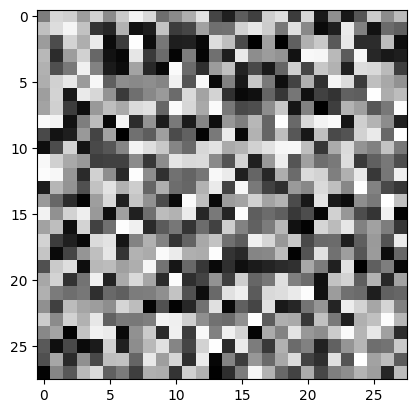

weights: torch.Size([10, 784])
bias:    torch.Size([10])


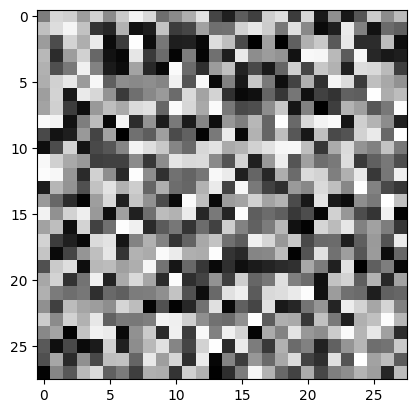

weights: torch.Size([10, 784])
bias:    torch.Size([10])


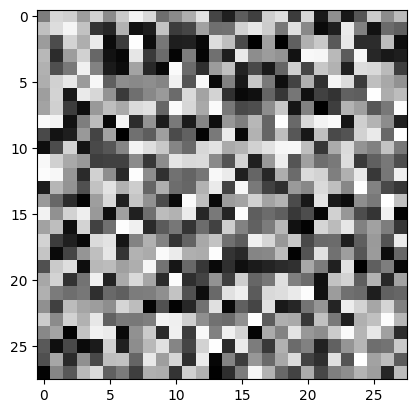

weights: torch.Size([10, 784])
bias:    torch.Size([10])


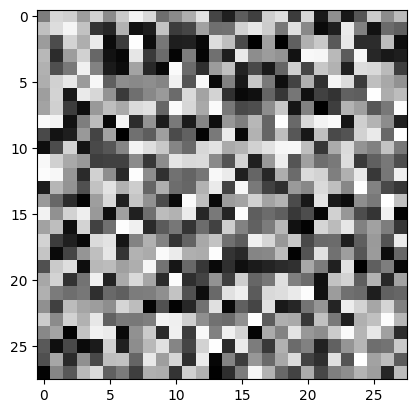

weights: torch.Size([10, 784])
bias:    torch.Size([10])


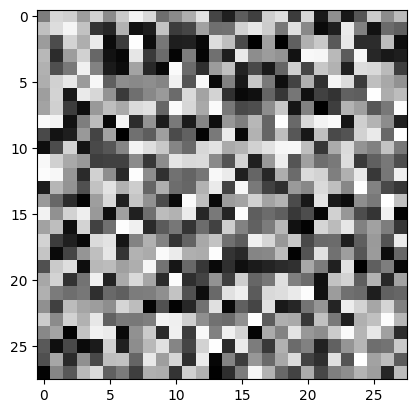

weights: torch.Size([10, 784])
bias:    torch.Size([10])


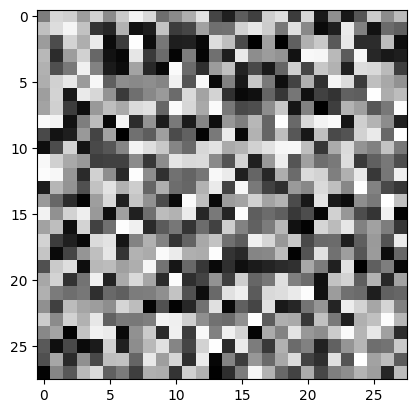

weights: torch.Size([10, 784])
bias:    torch.Size([10])


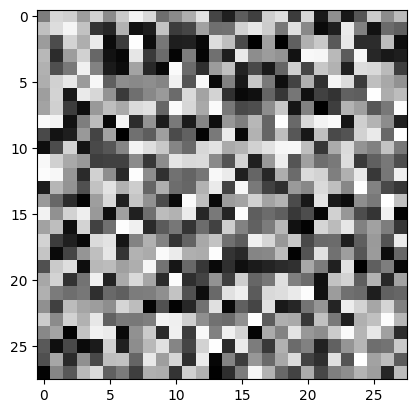

weights: torch.Size([10, 784])
bias:    torch.Size([10])


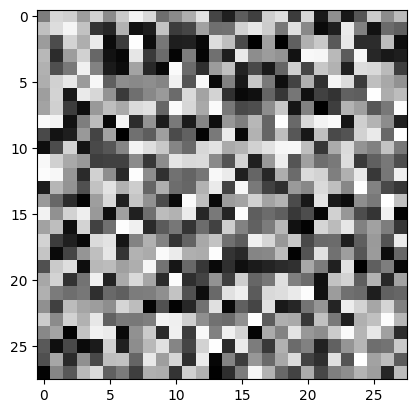

weights: torch.Size([10, 784])
bias:    torch.Size([10])


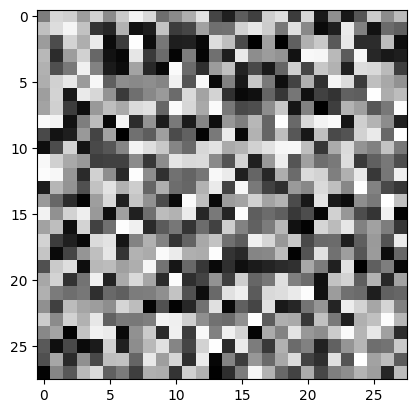

weights: torch.Size([10, 784])
bias:    torch.Size([10])


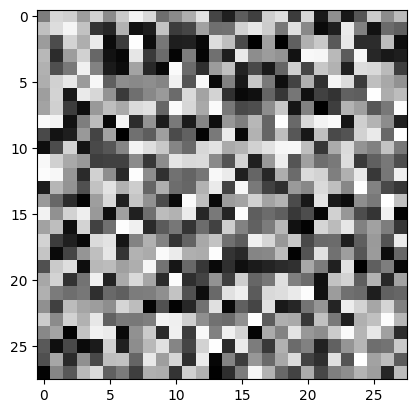

weights: torch.Size([10, 784])
bias:    torch.Size([10])


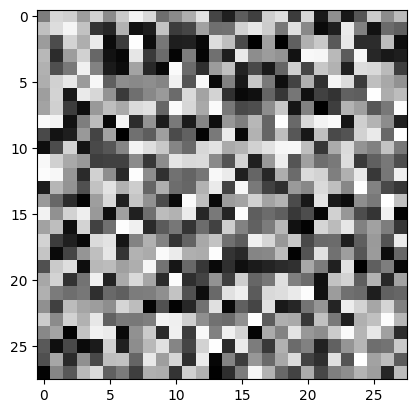

weights: torch.Size([10, 784])
bias:    torch.Size([10])


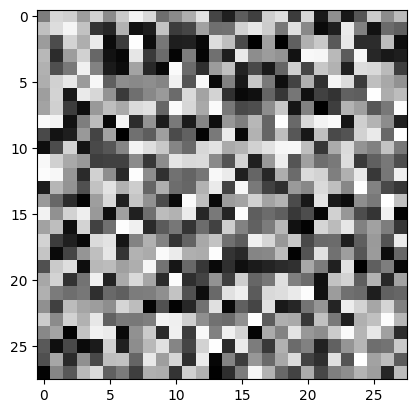

weights: torch.Size([10, 784])
bias:    torch.Size([10])


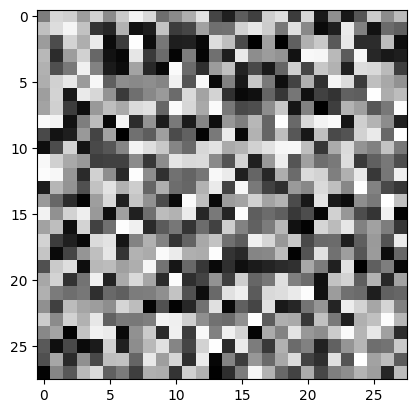

weights: torch.Size([10, 784])
bias:    torch.Size([10])


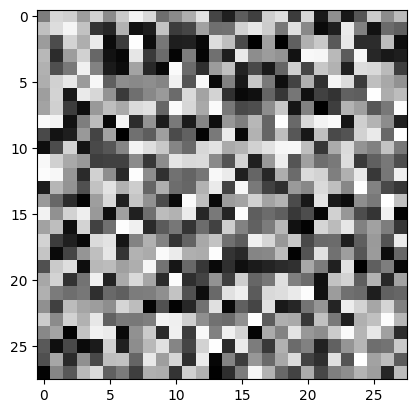

weights: torch.Size([10, 784])
bias:    torch.Size([10])


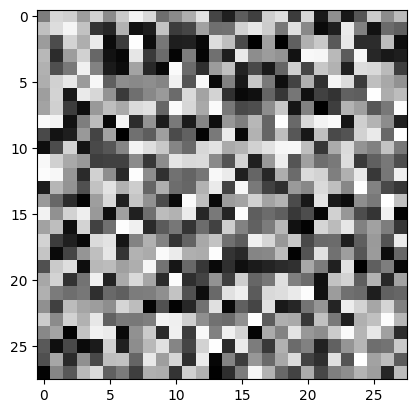

weights: torch.Size([10, 784])
bias:    torch.Size([10])


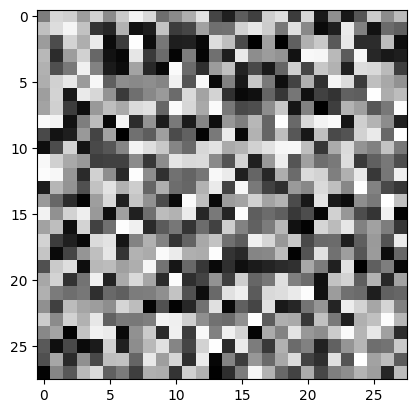

weights: torch.Size([10, 784])
bias:    torch.Size([10])


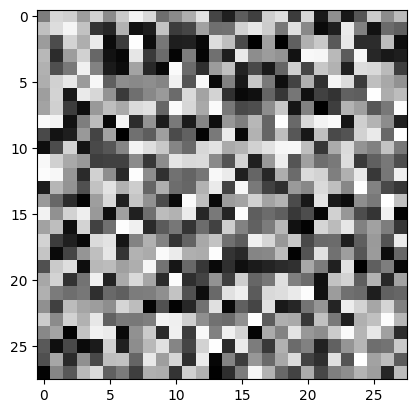

weights: torch.Size([10, 784])
bias:    torch.Size([10])


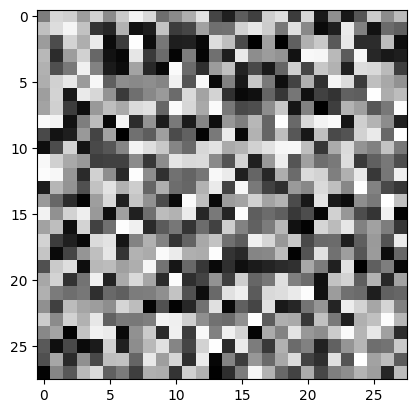

weights: torch.Size([10, 784])
bias:    torch.Size([10])


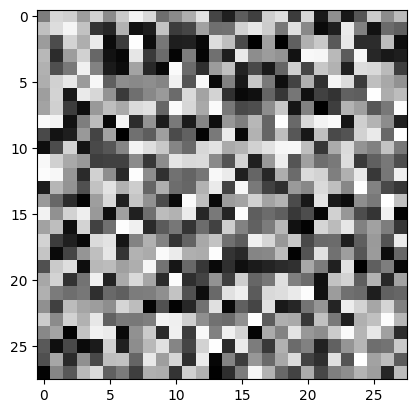

weights: torch.Size([10, 784])
bias:    torch.Size([10])


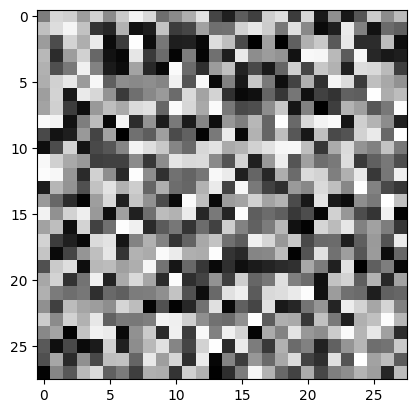

weights: torch.Size([10, 784])
bias:    torch.Size([10])


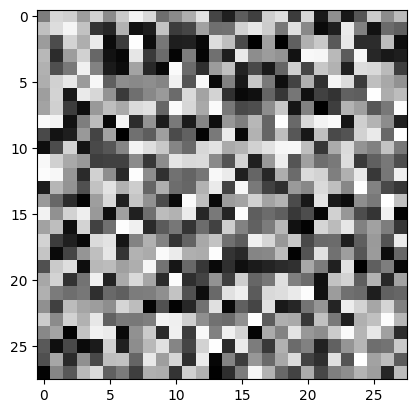

weights: torch.Size([10, 784])
bias:    torch.Size([10])


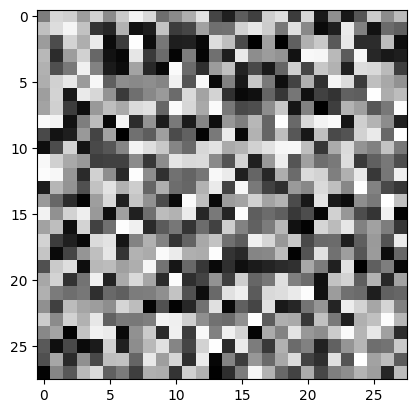

weights: torch.Size([10, 784])
bias:    torch.Size([10])


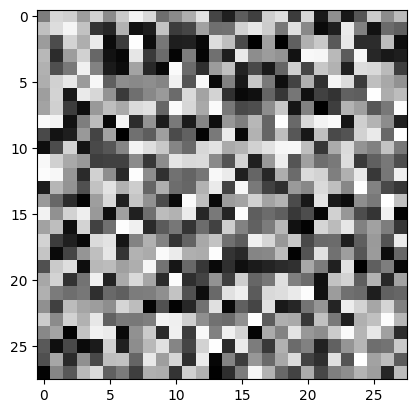

weights: torch.Size([10, 784])
bias:    torch.Size([10])


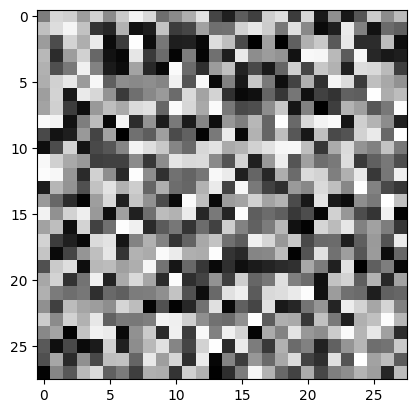

weights: torch.Size([10, 784])
bias:    torch.Size([10])


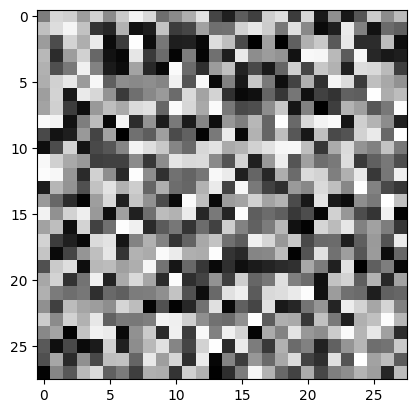

weights: torch.Size([10, 784])
bias:    torch.Size([10])


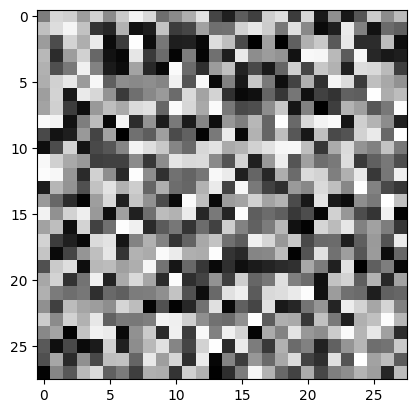

weights: torch.Size([10, 784])
bias:    torch.Size([10])


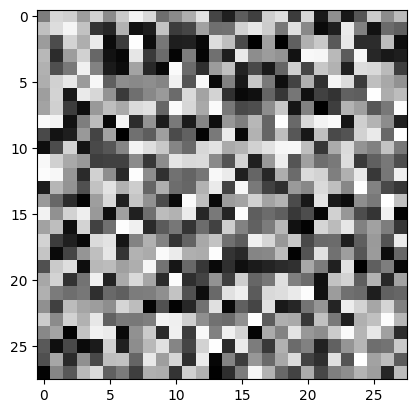

weights: torch.Size([10, 784])
bias:    torch.Size([10])
weights: torch.Size([10, 784])
bias:    torch.Size([10])


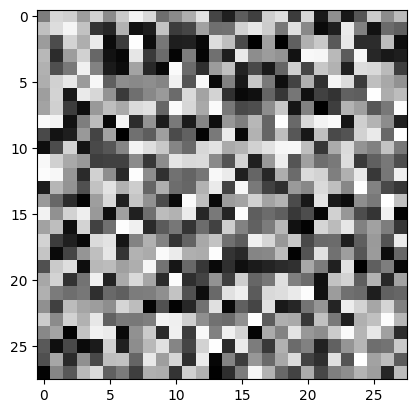

weights: torch.Size([10, 784])
bias:    torch.Size([10])


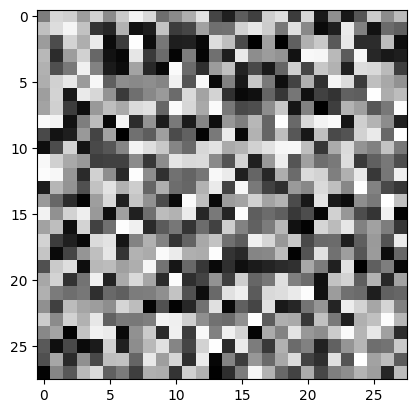

weights: torch.Size([10, 784])
bias:    torch.Size([10])


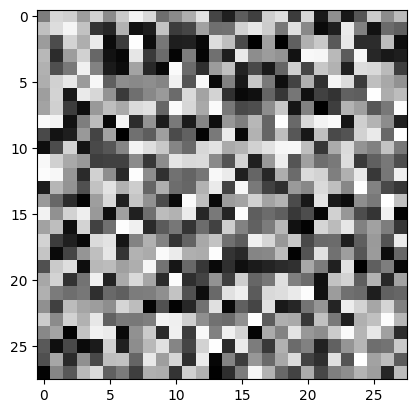

In [24]:
#2
model_2 = torch.nn.Linear(28*28, 10)
epochs = 100
learningRate = 0.5

criterion_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.SGD(model.parameters(), lr=learningRate)

losses = []
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model_2(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion_2(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer_2.zero_grad()
    loss.backward()
    optimizer_2.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    weights_2 = model_2.state_dict()['weight']
    print('weights:', weights_2.shape)

    bias_2 = model_2.state_dict()['bias']
    print('bias:   ', bias_2.shape)

    plt.imshow(weights_2[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()

## Perguntas

1. Qual é o shape da matriz de entrada na rede?
2. Qual é o shape da saída da rede?
3. Qual é o número total de parâmetros da rede, incluindo o bias?

# Aprendizados
